In [1]:
import importlib
import os
import sys

import pyro
import pyro.optim
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO

import torch
import torch.distributions.constraints as constraints

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
#!pip3.6 install tabulate
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path: sys.path.append(module_path)
import gaussian_class
import general.utility_functions

pyro.enable_validation(True)
pyro.set_rng_seed(42)
torch.manual_seed(42)

# Data generation

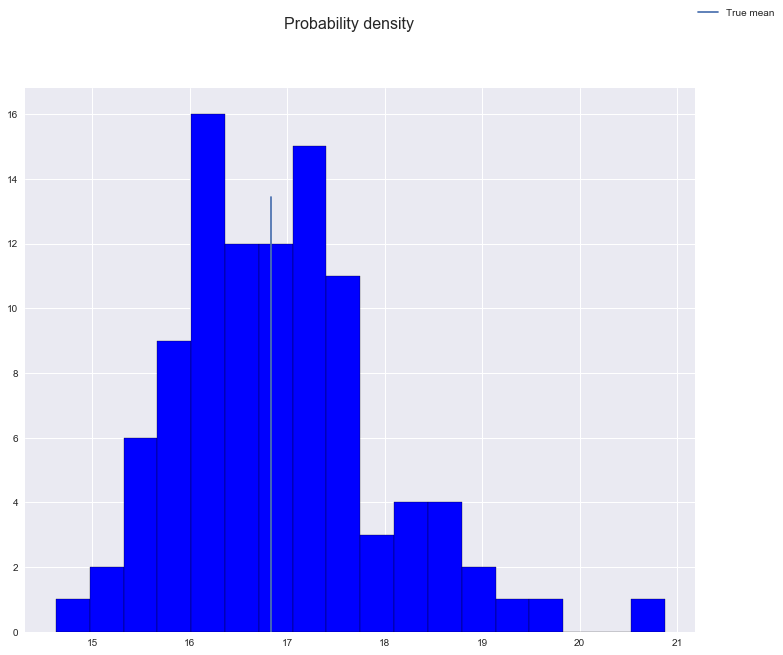

In [2]:
#toy data
def generate_data(N=1000, mean_scale = 1, mean_loc=0, std=1):
    #generating parameters of the gaussian
    mean =  torch.distributions.Normal(mean_loc,mean_scale).sample()
    
    #generating points
    data = torch.distributions.Normal(mean, std).sample([N])
    return {"data":data, 
            "mean":mean, 
            "std":std,
           'mean_loc':mean_loc,
            'mean_scale': mean_scale}



def plot_data(data, mean = None):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
    fig.suptitle("Probability density", fontsize=16)
    if mean is not None:
        axs.axvline(mean, 0, 0.8, label = f"True mean")
    axs.hist(data, bins = int(180/10),
            color = 'blue', edgecolor = 'black')
    #sns.distplot(data, ax=axs, label=f"Data")
    handles, labels = axs.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right');
    #fig.show()

N=100
mean_scale=50
data = generate_data(N=N, mean_scale=mean_scale)
keys_of_interest = ["data","mean", "std"]
points, mean, std = tuple(map(lambda x: data[x], keys_of_interest))
plot_data(points, mean)

# Training SVI and running MCMC

Training SVI
Step: 0, Elbo loss: -957.04
Step: 500, Elbo loss: -32465.76
Step: 1000, Elbo loss: -146.82
Step: 1500, Elbo loss: -2706.08
Step: 2000, Elbo loss: -158.27
Step: 2500, Elbo loss: -151.92
Step: 3000, Elbo loss: -152.28


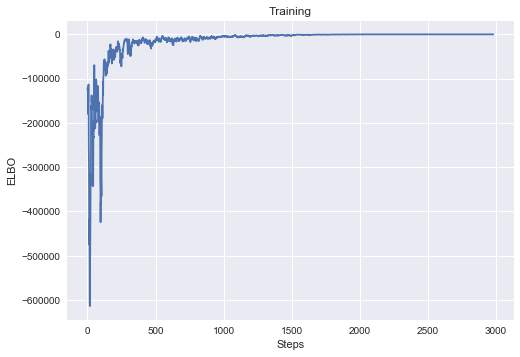

Warmup:   0%|          | 0/3600 [00:00, ?it/s]

Running MCMC for 3600 iterations to generate 3000 samples.


Sample: 100%|██████████| 3600/3600 [00:21, 165.46it/s, step size=9.10e-01, acc. prob=0.928]

{'mean': tensor([16.8338, 16.8967, 16.8536,  ..., 16.8259, 16.8523, 17.0297])}

In [15]:
#in case changes were made in the files, reload them
importlib.reload(general.utility_functions)
importlib.reload(general.model)
importlib.reload(gaussian_class) 

test = 0

#initialise the class
gaussian = gaussian_class.Gaussian(data)

#train svi
num_iters = 10 if test else 3000
#pyro.clear_param_store()
gaussian.train_svi(num_iters = num_iters, lr = 0.01)

#run mcmc
gaussian.run_mcmc(num_iters)





In [5]:
print(list(pyro.get_param_store().items()))

[('mean_loc', tensor(16.8839, requires_grad=True)), ('mean_scale', tensor(0.0963, grad_fn=<AddBackward0>))]


# Analysing SVI and MCMC. Posterior and predctive posterior
 

In [2]:
#samples plotting + PPC for SVI and MCMC
samples_dict = {}
svi_parameter = [True]#, False]
for svi in svi_parameter:
    print(f"Summarising {'SVI' if svi else 'MCMC'}")
    print("First, posterior samples")
    gaussian.compare_posterior_samples(svi=svi, num_posterior_samples=100, show_percentile=True)
    samples = gaussian.get_predictive_posterior_samples(svi=svi, num_posterior_samples = 100, data_len=100)
    print(samples['obs'].shape)
    gaussian.plot_sim_vs_real(samples['obs'])
    print(general.utility_functions.predictive_checks(samples['obs'], gaussian.data))
    #for future
    if svi: 
        samples_dict['svi'] = samples['obs']
    else:
        samples_dict['mcmc'] = samples['obs']


NameError: name 'normal' is not defined

# PPVB 

Training SVI
Step: 0, Elbo loss: -261348.30
Step: 500, Elbo loss: -8250.00
Step: 1000, Elbo loss: -4934.75
Step: 1500, Elbo loss: -3054.51
Step: 2000, Elbo loss: -460.82
Step: 2500, Elbo loss: -5.34
Step: 3000, Elbo loss: -12.93


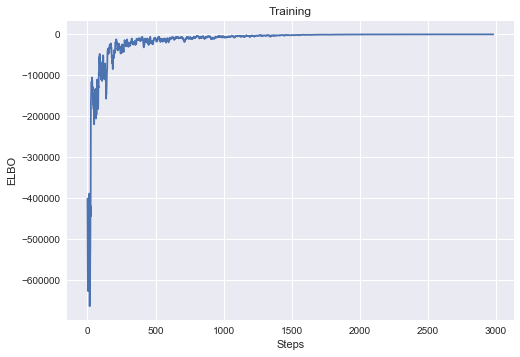

<bound method Gaussian.pp_guide of <gaussian_class.Gaussian object at 0x7fefce7f7cc0>>

In [43]:
#PPVB
# #in case changes were made in the files, reload them
importlib.reload(general.utility_functions)
importlib.reload(general.model)
importlib.reload(gaussian_class) 

#initialise the class
gaussian = gaussian_class.Gaussian(data)


gaussian.train_svi(ppvb=True, num_iters = 3000, lr = 0.01, ppvb_batch_size = 10)

In [41]:
list(pyro.get_param_store().items())

[('mean_loc', tensor(16.9152, requires_grad=True)),
 ('mean_scale', tensor(0.1032, grad_fn=<AddBackward0>)),
 ('pred_mean_loc', tensor(16.9345, requires_grad=True)),
 ('pred_mean_scale', tensor(0.3599, grad_fn=<AddBackward0>)),
 ('pred_scale_loc', tensor(10., grad_fn=<AddBackward0>))]

# Analysing PPVB

Shape is torch.Size([100, 100])
stat                 stat(obs)            mean(stat(sim))         std(stat(sim))
-------------------  -------------------  ---------------------  --------------------
shape                (100,)               (100, 100)
mean                 16.91848373413086    16.8751163482666       0.32925209403038025
std                  1.031678557395935    0.9801153540611267     0.0820847749710083
median               16.856300354003906   16.874317169189453     0.33672186732292175
mode                 [14.62812]           14.386933326721191     0.4947005808353424
skewness             0.8579136197460707   -0.023960979655385017  0.006348070222884417
kurtosis             4.368466291503871    3.2894463539123535     1.187349557876587
___________________  ___________________  ___________________    ___________________
Done


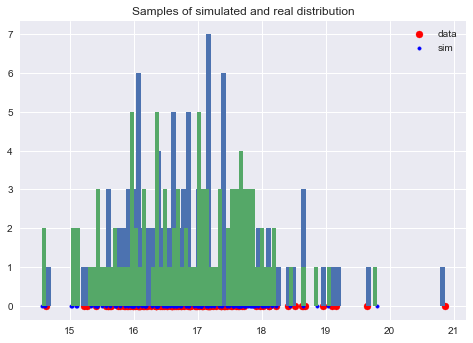

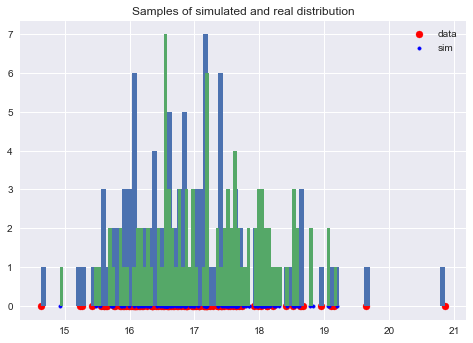

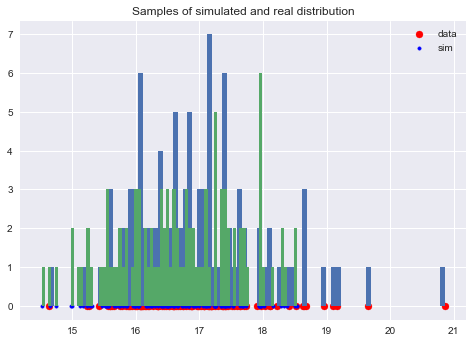

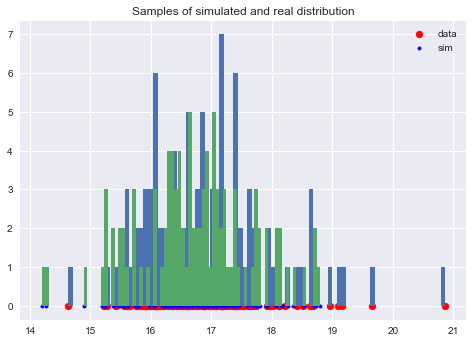

In [40]:
predictive_samples = gaussian.sample_ppvb(num_samples = 100, data_len = 100)
print(general.utility_functions.predictive_checks(predictive_samples.cpu().numpy(), gaussian.data))
gaussian.plot_sim_vs_real(predictive_samples.cpu().numpy(), num_im=4)

# Snelson reimplementation 

Okay, what I am trying to achieve here?
Implementing Snelson. What does it mean?
1. Split Gaussian into the parts of exponential distribution. 
2. E step Get likelihood function (p(x', y'|\theta^), posterior of latent (p(xi|yi, \theta^), prior (\theta| \n^, v^) and set them to be the guides
3. M step Update \theta^, \n^, v^. 



equation 58 of https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf

We will have the simplest Gaussian possible: known variance, unkown mean. Variance will be 1 and there will be no latent variables.

In [13]:
#in case changes were made in the files, reload them
importlib.reload(general.utility_functions)
importlib.reload(general.model)
importlib.reload(gaussian_class) 

STD  = 1
#initialise the class
gaussian = gaussian_class.Gaussian(data)
def snelson_guide(data, data_len = None, qy = 0, iteration=None):   
    data_len = gaussian._get_data_len(data_len)
    #priors \eta and \v
    v = pyro.param("v", torch.tensor(0.)) # the loc of prior of the mean, "pseudovalue"
    eta = pyro.param("eta", torch.tensor(1.)) #the scale of prior of hte mean, "pseudocounts"
    #initialisation

    if iteration == 0: # if it's the first iteration, use the prior, since E step is first 
        eta_tilde = eta
        v_tilde = v
    else: # update, do M step 
        eta_tilde = 1/(eta + len(data) + 1)
        v_tilde = (v/eta + qy/STD + torch.sum(data)/STD)*eta_tilde

    #mean sample
    mean_tilde = pyro.sample("mean_tilde", dist.Normal(loc=v_tilde, scale=eta_tilde))
    #predictive likelhood q(y|mean_tilde)
    with pyro.plate('data', data_len):
        pyro.sample("pred", dist.Normal(loc=mean_tilde, scale=STD))
    
    
def snelson_update(model, guide, data, qy=None, i=0):
    trace = pyro.poutine.trace(pyro.poutine.block(guide, hide=["mean_sample"])).get_trace(data, 1, qy, i)
    qy = trace.nodes['pred']['value']
    return qy
    
num_steps = 1000
print_every = 100
qy = 0
pyro.clear_param_store()
with torch.no_grad(): # since all updates are manual, we can speed things up by disregarding grad
    for i in range(num_steps+1):
        qy = snelson_update(gaussian.model, snelson_guide, gaussian.data, qy, i)
        if i%print_every == 0:
            print(f"iter {i}, y' {qy.item() :.2f}")



iter 0, y' -1.10
iter 100, y' 17.51
iter 200, y' 17.32
iter 300, y' 14.11
iter 400, y' 16.79
iter 500, y' 15.66
iter 600, y' 16.55
iter 700, y' 14.33
iter 800, y' 17.59
iter 900, y' 16.11
iter 1000, y' 17.54


Shape is torch.Size([100, 1000])
stat                 stat(obs)            mean(stat(sim))         std(stat(sim))
-------------------  -------------------  ---------------------  ---------------------
shape                (100,)               (100, 1000)
mean                 16.91848373413086    16.753324508666992     0.03243715688586235
std                  1.031678557395935    0.9982183575630188     0.022375809028744698
median               16.856300354003906   16.755952835083008     0.04238077625632286
mode                 20.87015151977539    19.99521255493164      0.42068782448768616
skewness             0.8579136197460707   -0.010204043239355087  0.0006888310890644789
kurtosis             4.368466291503871    3.032785654067993      0.27353888750076294
___________________  ___________________  ___________________    ___________________
Done


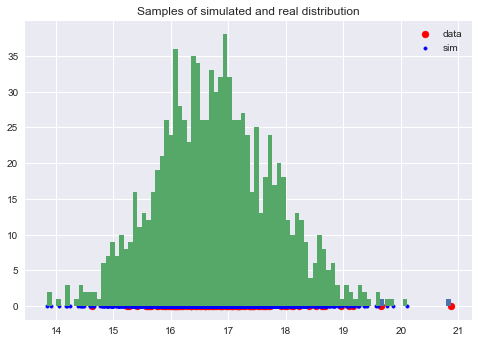

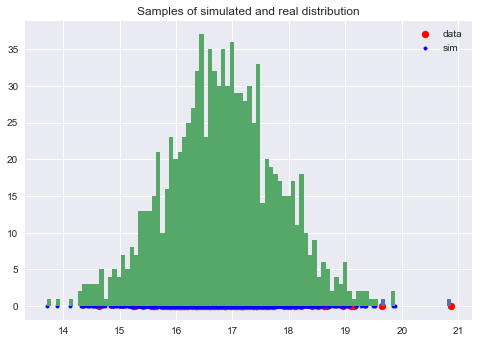

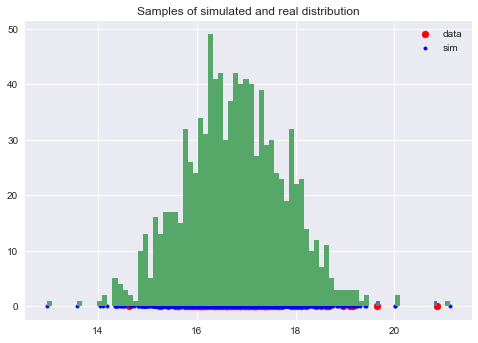

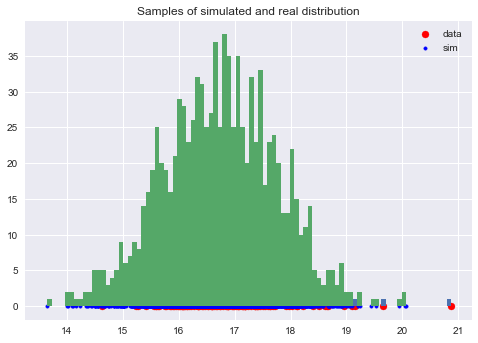

In [14]:
def sample_snelson(guide, data = None, num_samples = 10,  data_len = None, qy_init = 0):
    data_len = gaussian._get_data_len(data_len)
    with torch.no_grad():
        predictive_samples = torch.empty((num_samples, data_len))
        for i in range(num_samples):
            guide_trace = pyro.poutine.trace(guide).get_trace(data, data_len, qy_init, 1)
            predictive_samples[i] = guide_trace.nodes['pred']['value']
    print("Shape is", predictive_samples.shape)
    return predictive_samples
predictive_samples = sample_snelson(snelson_guide, gaussian.data, num_samples =100, data_len=1000, qy_init = qy)



print(general.utility_functions.predictive_checks(predictive_samples.cpu().numpy(), gaussian.data))
gaussian.plot_sim_vs_real(predictive_samples.cpu().numpy(), num_im=4)

# Exact Predictive Posterior for this model N(mu, 1) . mu \sample N(mu_0, sigma_0)

In [8]:
def exact_predictive_posterior(data, std = 1, sigma_0 = 1, mu_0 = 0):
    n = len(data)
    sigma_posterior =  1/(1/sigma_0 + n/std)
    mu_predictive = sigma_posterior * (mu_0/sigma_0 + torch.sum(data)/std)
    sigma_predictive  = sigma_posterior + std
    return dist.Normal(mu_predictive, sigma_predictive)

pred_post = exact_predictive_posterior(gaussian.data,1, 100, 0)

In [42]:
print("PPVB")
print(general.utility_functions.predictive_checks(predictive_samples.cpu().numpy(), pred_post.sample([1000]).cpu().numpy()))

stat                 stat(obs)            mean(stat(sim))         std(stat(sim))
-------------------  -------------------  ---------------------  --------------------
shape                (1000,)              (100, 100)
mean                 16.893295288085938   16.8751163482666       0.32925209403038025
std                  0.9980804920196533   0.9801153540611267     0.0820847749710083
median               16.8956241607666     16.874317169189453     0.33672186732292175
mode                 [13.443635]          14.386933326721191     0.4947005808353424
skewness             0.03227392612464263  -0.023960979655385017  0.006348070222884417
kurtosis             3.0241755233563823   3.2894463539123535     1.187349557876587
___________________  ___________________  ___________________    ___________________
Done


In [14]:
print("SVI")
print(general.utility_functions.predictive_checks(samples['obs'], pred_post.sample([100]).cpu().numpy()))

stat                 stat(obs)            mean(stat(sim))        std(stat(sim))
-------------------  -------------------  --------------------  --------------------
shape                (100,)               (100, 100)
mean                 16.806190490722656   16.940345764160156    0.13619685173034668
std                  0.901760995388031    0.9906085729598999    0.07465572655200958
median               16.839801788330078   16.941442489624023    0.15806369483470917
mode                 [14.535547]          14.403807640075684    0.4251014292240143
skewness             0.1620467827357153   -0.01821979321539402  0.004168723244220018
kurtosis             2.9731145057285047   3.2187039852142334    0.9866899251937866
___________________  ___________________  ___________________   ___________________
Done
